# Classification problem : Multinomial Naive Bayes trained on the Dataset

In [3]:
#Imports
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from keras.preprocessing import sequence
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder


### We load the data.

In [4]:
#We load the data
data_path = "Data/GSM3130435_egfp_unmod_1_PREPROCESSED.csv.gz"
df = pd.read_csv(data_path, compression='gzip')

In [5]:
df.head()

,Unnamed: 0,utr,0,1,2,3,4,5,6,7,...,r9,r10,r11,r12,r13,rl,Selection,one-hot encoding,Length,scaled_rl
0,120605,CCACTCGATTAACATGTTAACAACATACTCGTCCGGCCGATCAGCG...,0.000137,0.000109,0.000057,0.000033,0.000015,0.000016,0.000009,0.000009,...,0.019283,0.033252,0.033252,0.027581,0.035877,3.039939,Selected Data,"[[0, 1, 0, 0], [0, 1, 0, 0], [1, 0, 0, 0], [0,...",50,-2.130922
1,11605,CAAATCATGTGCAGCCCTGGCGACCGTACTGCGGTACAAGAAAGTA...,0.000067,0.000070,0.000065,0.000048,0.000023,0.000020,0.000011,0.000011,...,0.024241,0.039457,0.039457,0.039840,0.038785,3.895109,Selected Data,"[[0, 1, 0, 0], [1, 0, 0, 0], [1, 0, 0, 0], [1,...",50,-1.600332
2,128224,GTTATACTAGAAGAAACTTGAGATTATGGAGCAGTCCGTCAAGGAC...,0.000088,0.000081,0.000059,0.000035,0.000017,0.000016,0.000009,0.000009,...,0.021591,0.028353,0.028353,0.028963,0.041985,3.334524,Selected Data,"[[0, 0, 1, 0], [0, 0, 0, 1], [0, 0, 0, 1], [1,...",50,-1.948147
3,239107,CTTAGACAAAAACAACGCGCTTTCCAGTATGCGGAGCCTTGACGGT...,0.000078,0.000071,0.000060,0.000038,0.000025,0.000016,0.000010,0.000009,...,0.026617,0.038302,0.038302,0.032788,0.031043,3.575082,Selected Data,"[[0, 1, 0, 0], [0, 0, 0, 1], [0, 0, 0, 1], [1,...",50,-1.798893
4,59082,GTATCAAATCACGGCCAACCCGACGGAGTACCCCGCGTCGATGGTC...,0.000044,0.000045,0.000050,0.000051,0.000033,0.000026,0.000015,0.000012,...,0.033080,0.051449,0.051449,0.046052,0.036447,4.593712,Selected Data,"[[0, 0, 1, 0], [0, 0, 0, 1], [1, 0, 0, 0], [0,...",50,-1.166885


### We transform our problem in a classification task.

#### First, we transform the output. 

In [6]:
df['Round MRL'] = df['rl'].apply(round)
df['Round MRL']

0         3
1         4
2         3
3         4
4         5
         ..
279995    8
279996    8
279997    8
279998    3
279999    5
Name: Round MRL, Length: 280000, dtype: int64

In [7]:
print(len(df['Round MRL'].unique()))
df['Round MRL'].unique()

13


array([ 3,  4,  5,  8,  6,  7,  2,  9,  0,  1, 10, 11, 12])

We thus obtain 13 classes. Let us observe the repartition of the classes. 

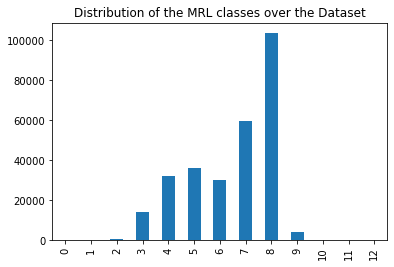

In [8]:
df['Round MRL'].value_counts().sort_index().plot.bar()
plt.title("Distribution of the MRL classes over the Dataset")
plt.show()

There is class imbalance. 

In [9]:
#Let us compute class weights 
#First, we have to compute a dictionnary with the counts per class
values = list(df['Round MRL'].unique())
counts = dict()
for value in values:
    counts[value] = df['Round MRL'].value_counts()[value]
counts

{3: 13883,
 4: 32024,
 5: 35956,
 8: 103568,
 6: 30255,
 7: 59431,
 2: 770,
 9: 3898,
 0: 11,
 1: 57,
 10: 126,
 11: 18,
 12: 3}

In [10]:
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight("balanced", np.unique(df["Round MRL"]), df["Round MRL"])

/Users/mariehuynh/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:67: FutureWarning: Pass classes=[ 0  1  2  3  4  5  6  7  8  9 10 11 12], y=0         3
1         4
2         3
3         4
4         5
         ..
279995    8
279996    8
279997    8
279998    3
279999    5
Name: Round MRL, Length: 280000, dtype: int64 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


In [11]:
le = preprocessing.LabelEncoder() 
le.fit(df["Round MRL"])
class_weights_dict = dict(zip(le.transform(list(le.classes_)), class_weights)) 

## Case 1 : Using k-mer Counting

In [12]:
# function to convert sequence strings into k-mer words, default size = 6 (hexamer words)
def getKmers(sequence, size=6):
    return [sequence[x:x+size].lower() for x in range(len(sequence) - size + 1)]

In [13]:
df['words'] = df['utr'].apply(lambda x: getKmers(x))
df['words'].head()

0    [ccactc, cactcg, actcga, ctcgat, tcgatt, cgatt...
1    [caaatc, aaatca, aatcat, atcatg, tcatgt, catgt...
2    [gttata, ttatac, tatact, atacta, tactag, actag...
3    [cttaga, ttagac, tagaca, agacaa, gacaaa, acaaa...
4    [gtatca, tatcaa, atcaaa, tcaaat, caaatc, aaatc...
Name: words, dtype: object

In [14]:
df_text = list(df['words'])
for item in range(len(df_text)):
    df_text[item] = ' '.join(df_text[item])
y_data = df['Round MRL'].values     

In [15]:
print(df_text[1])

caaatc aaatca aatcat atcatg tcatgt catgtg atgtgc tgtgca gtgcag tgcagc gcagcc cagccc agccct gccctg ccctgg cctggc ctggcg tggcga ggcgac gcgacc cgaccg gaccgt accgta ccgtac cgtact gtactg tactgc actgcg ctgcgg tgcggt gcggta cggtac ggtaca gtacaa tacaag acaaga caagaa aagaaa agaaag gaaagt aaagta aagtat agtata gtatag tatagt


In [16]:
print(y_data)

[3 4 3 ... 8 3 5]


In [17]:
# Creating the Bag of Words model using CountVectorizer()
# This is equivalent to k-mer counting
# The n-gram size of 4 was previously determined by testing
cv = CountVectorizer(ngram_range=(3,3)) #ngram_range=(4,4))
X = cv.fit_transform(df_text)

In [18]:
print(X.shape)


(280000, 65536)


### We split our data into training and testing set.

In [39]:
X_train = X[20000:]
y_train = y_data[20000:]
X_test = X[:20000]
y_test = y_data[:20000]

### Multinomial NB

In [40]:
classifier = MultinomialNB(alpha=0.01)
classifier.fit(X_train, y_train)

MultinomialNB(alpha=0.01)

In [41]:
y_pred = classifier.predict(X_test)

In [42]:
cm = confusion_matrix(y_test, y_pred)
cm

array([[   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0],
       [   0,    0,    0,   15,    8,    0,    1,    3,    0,    1,    1,
           0,    0],
       [   0,    0,    0,  654, 1032,  517,  140,  244,   94,    7,    1,
           2,    4],
       [   1,    0,    0,  520, 1457, 1289,  465,  376,  161,   15,    1,
           1,    8],
       [   1,    0,    0,  158,  613, 1053,  666,  398,  148,   18,    1,
           0,    9],
       [   0,    0,    0,   36,  155,  420,  578,  380,  122,   11,    0,
           0,    3],
       [   0,    0,    0,   65,  148,  186,  289, 1105,  555,    5,    0,
           0,    5],
       [   2,    1,    1,   72,  246,  310,  295, 1026, 3728,   37,    0,
           1,   15],
       [   0,    0,    0,    3,   13,   17,   16,    1,   64,    6,    0,
           0,    0],
       [   0,    0,    0,    0,    0,    0,    0, 

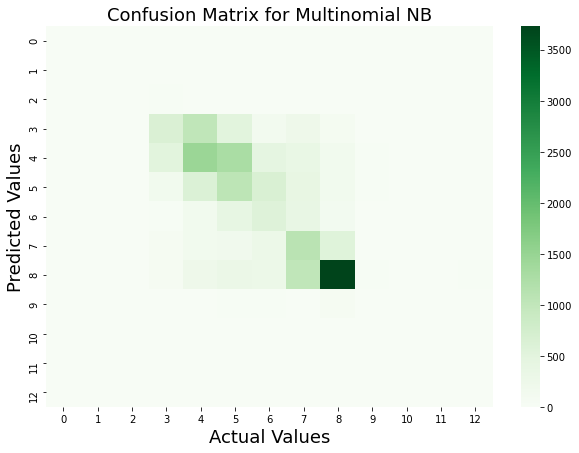

In [56]:
import pandas as pd
import matplotlib.pyplot as plt

df_cm = pd.DataFrame(cm, index = [i for i in range(13)],
                  columns = [i for i in range(13)])
plt.figure(figsize = (10,7))
plt.title("Confusion Matrix for Multinomial NB", fontsize=18)
sns.heatmap(df_cm, annot=False, cmap="Greens")
plt.xlabel("Actual Values", fontsize=18)
plt.ylabel("Predicted Values", fontsize=18)
plt.show()

In [57]:
def get_metrics(y_test, y_predicted):
    accuracy = accuracy_score(y_test, y_predicted)
    precision = precision_score(y_test, y_predicted, average='weighted')
    recall = recall_score(y_test, y_predicted, average='weighted')
    f1 = f1_score(y_test, y_predicted, average='weighted')
    return accuracy, precision, recall, f1
accuracy, precision, recall, f1 = get_metrics(y_test, y_pred)

print("accuracy = %.3f \nprecision = %.3f \nrecall = %.3f \nf1 = %.3f" % (accuracy, precision, recall, f1))

accuracy = 0.429 
precision = 0.462 
recall = 0.429 
f1 = 0.437


/Users/mariehuynh/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Case 2 : Using tokenizers

In [46]:
e_train = df[20000:]
e_test = df[:20000]

In [47]:
def tokenize(df, col='utr', seq_len=50):
    # Dictionary returning one-hot encoding of nucleotides. 
    nuc_d = {'a':1,'c':2,'g':3,'t':4, 'n' : 5}
    
    vectors=np.empty([len(df),seq_len])
    
    for i,seq in enumerate(df[col].str[:seq_len]): 
        seq = seq.lower()
        a = np.array([nuc_d[x] for x in seq])
        vectors[i] = a
    return vectors

In [48]:
# Tokenize both training and test UTRs
seq_e_train = tokenize(e_train, seq_len=50)
seq_e_test = tokenize(e_test, seq_len=50)
seq_e_train

array([[2., 2., 3., ..., 2., 1., 2.],
       [1., 1., 4., ..., 4., 2., 1.],
       [2., 2., 3., ..., 2., 4., 1.],
       ...,
       [3., 3., 4., ..., 1., 4., 1.],
       [2., 2., 3., ..., 3., 3., 1.],
       [2., 2., 3., ..., 3., 1., 1.]])

In [49]:
# Splitting the human dataset into the training set and test set
X_train2, X_test2, y_train2, y_test2 = train_test_split(seq_e_train, 
                                                    e_train['Round MRL'], 
                                                    test_size = 0.20, 
                                                    random_state=42)

In [53]:
classifier2 = MultinomialNB(alpha=0.01)
classifier2.fit(X_train2, y_train2)

MultinomialNB(alpha=0.01)

In [54]:
y_pred2 = classifier2.predict(X_test2)

In [55]:
def get_metrics(y_test, y_predicted):
    accuracy = accuracy_score(y_test, y_predicted)
    precision = precision_score(y_test, y_predicted, average='weighted')
    recall = recall_score(y_test, y_predicted, average='weighted')
    f1 = f1_score(y_test, y_predicted, average='weighted')
    return accuracy, precision, recall, f1
accuracy, precision, recall, f1 = get_metrics(y_test2, y_pred2)

print("accuracy = %.3f \nprecision = %.3f \nrecall = %.3f \nf1 = %.3f" % (accuracy, precision, recall, f1))

accuracy = 0.379 
precision = 0.144 
recall = 0.379 
f1 = 0.208


/Users/mariehuynh/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
